# Toy Data: 8-Modes Mixture Model

In [1]:
#In this notebook we use the Freia package and it is heavily based on the notebook published by Ardizzone et al
#see https://github.com/VLL-HD/analyzing_inverse_problems and https://github.com/VLL-HD/analyzing_inverse_problems

# there will be two training blocks in this code. the first one was used to obtain a good first model, and then we did 
# training with more fine tuned weights. this mainly consisted in putting the L_x loss up and decaying the learn rate and
# l2 regularization

In [2]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom, NICECouplingBlock, GINCouplingBlock
import data

#Ensure reproducibility
torch.manual_seed(3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
1.7.1+cu101


<IPython.core.display.Javascript object>


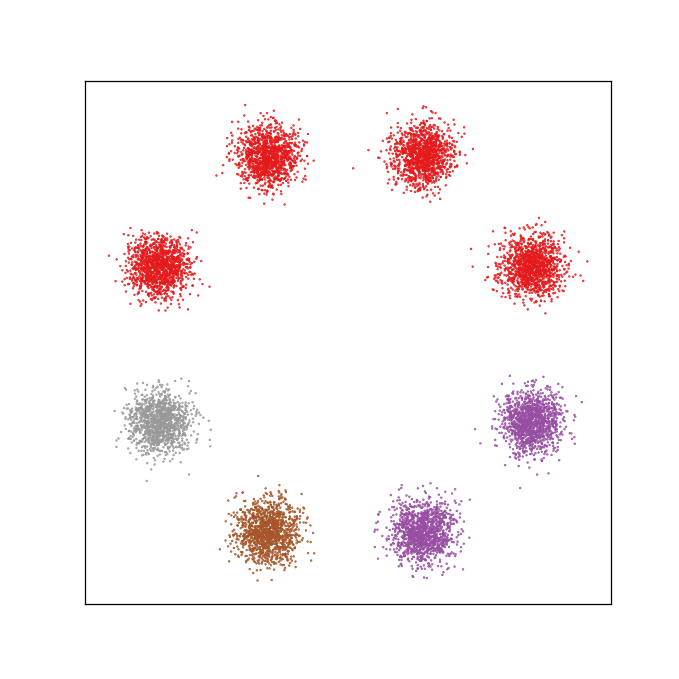

In [3]:
# Generate data
test_split = 10000

pos, labels = data.generate(labels='some', tot_dataset_size=2**20)
labels = labels[:,:4]

#Visualize data
c = np.where(labels[:test_split])[1]
plt.figure(figsize=(6, 6))
plt.scatter(pos[:test_split, 0], pos[:test_split, 1], c=c, cmap='Set1', s=0.25)
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
#Problem Dimensions with padding
ndim_tot = 16
ndim_x = 2
ndim_y = 4
ndim_z = 2

# Construct INN architecture, clamping ensures Lipschitz continuity of network
def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 256), nn.ReLU(),
                         nn.Linear(256,  c_out))

nodes = [InputNode(ndim_tot, name='input')]
for k in range(6):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':0.01},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))
nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False).to(device)

# Construct NN for proabilities in GMM
prob_net = nn.Sequential(nn.Linear(4,64), nn.ReLU(),
                        nn.Linear(64,4), nn.Softmax(dim = 1)).to(device)



In [5]:
# Load pretrained model parameters
#model.load_state_dict(torch.load('STABLE_8_LL.pt'))
#prob_net.load_state_dict(torch.load('STABLE_8_LL_probs.pt'))


In [6]:
# Initial training parameters
n_epochs = 100
n_its_per_epoch = 8
batch_size = 1600

lr_INN = 5e-3
lr_prob = 1e-4
l2_reg = 2e-3 #3e-1

# relative weighting of losses:
lambd_predict = 12. #14
lambd_latent = 100.
lambd_rev = 200. 
lambd_pad = 5.
lambd_prob = 2.

Loss_ramp = True
Sparsity_Reg = False

# Parameters for GMM
gum = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]), validate_args=None)
temp = 0.2
no_gaussians = 4
means = torch.tensor([[-4,-4],[-4,+4],[4,4],[4.,-4.]], device = device)
scale = 1.

# Padding parameters
y_noise_scale = 1e-4
zeros_noise_scale= 1e-4

# Intialize trainable parameters
trainable_parameters = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(trainable_parameters, weight_decay = l2_reg,
  lr=lr_INN, betas=(0.8, 0.9),eps=1e-6)


prob_par = [p for p in prob_net.parameters() if p.requires_grad]

# Optimizer setup
#optimizer = torch.optim.Adam(trainable_parameters, lr=lr_INN, betas=(0.8, 0.9),
#                             eps=1e-6, weight_decay=l2_reg)
optimizer2 = torch.optim.Adam(prob_par, lr=lr_prob)


# Setup of loss functions
def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

# Data loading routine
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[:test_split], labels[:test_split]),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[test_split:], labels[test_split:]),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
def train(i_epoch=0):
    model.train()
    l_tot = 0
    batch_idx = 0
    
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.
    if Loss_ramp:
        loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
    else:
        loss_factor = 1.
    for x, y in train_loader:
        
        # Iterate over number of batches
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break
        optimizer.zero_grad()          
        optimizer2.zero_grad()

        #Pass and create data
        x, y = x.to(device), y.to(device)

        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y + y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)
        
        # Gumbel trick for sampling z
        probs = prob_net(y)
        gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
        logits = gumbs+torch.log(probs)
        maxi,index = torch.max(logits, dim = 1)
        maxi = maxi.view(len(maxi),1)
        maxi = torch.cat((maxi,maxi,maxi,maxi),1)
        logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
        #logits = torch.exp((logits/temp)-maxi)/torch.sum(torch.exp((logits/temp)-maxi), dim = 1).view(len(y),1)
        # Create an array of all possible mixture components with all means
        norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
        # Enlarge logits array to fit the size of norms
        logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
        # linearly combinate the mixture components
        q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
        # put it into z
        z = q+scale*torch.randn(len(y),ndim_z, device = device)
        
        # Pad vectors
        x, y = (torch.cat((x, pad_x),  dim=1),torch.cat((z, pad_yz, y),dim=1))
        
        # Forward step
        output = model(x)
        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)
        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])
        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)
        l += lambd_latent * loss_latent(output_block_grad, y_short)
        #l -= torch.mean(model.jacobian(x))
        l_tot += l.data.item()
        l.backward()

        # Backward step
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)
        probs = prob_net(y)

        gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
        logits = gumbs+torch.log(probs)
        maxi,index = torch.max(logits, dim = 1)
        maxi = maxi.view(len(maxi),1)
        maxi = torch.cat((maxi,maxi,maxi,maxi),1)
        logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
        #logits = torch.exp((logits/temp)-maxi)/torch.sum(torch.exp((logits/temp)-maxi), dim = 1).view(len(y),1)
        # Create an array of all possible mixture components with all means
        norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
        # Enlarge logits array to fit the size of norms
        logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
        # linearly combinate the mixture components
        q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
        # put it into z
        z = q+scale*torch.randn(len(y),ndim_z, device = device)
        
        
        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale * torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz, output.data[:, -ndim_y:]+ y_noise_scale * torch.randn(batch_size, ndim_y, device=device)), dim=1)
        output_rev = model(y_rev, rev=True)              
        y_rev_rand = torch.cat((z, pad_yz,y), dim=1)
        output_rev_rand = model(y_rev_rand, rev=True)
        l_rev = lambd_rev * loss_factor * loss_backward(
            output_rev_rand[:, :ndim_x],x[:, :ndim_x])
        
        # Add sparsity enforcing regularizer for probability vector
        if Sparsity_Reg:
            l_rev += 1* loss_factor * lambd_prob * torch.mean(torch.square(torch.sum(torch.sqrt(probs),1)))
        
        l_rev += lambd_predict * loss_fit(output_rev, x)
        l_rev += lambd_pad*torch.mean(output_rev_rand[:,ndim_x:]**2)

        
        l_tot += l_rev.data.item()
        l_rev.backward()

        # Clamping and optimizer steps
        for p in model.parameters():
            p.grad.data.clamp_(-15.00, 15.00)
            
        for p in prob_net.parameters():
            p.grad.data.clamp_(-1.00, 1.00)
        optimizer.step()
        optimizer2.step()

    return l_tot / batch_idx

<IPython.core.display.Javascript object>


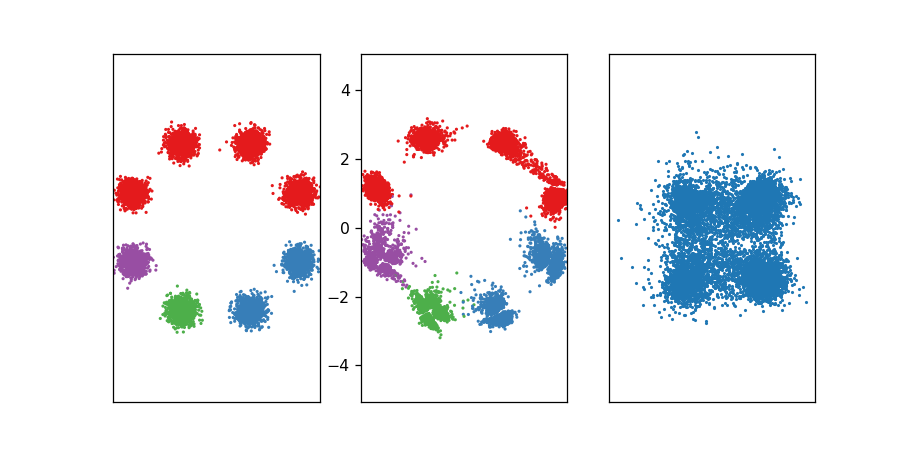

  0%|                                                   | 0/100 [00:00<?, ?it/s]

tensor([[0.2501, 0.2483, 0.2503, 0.2514],
        [0.2501, 0.2483, 0.2503, 0.2514],
        [0.2501, 0.2483, 0.2502, 0.2514],
        [0.2500, 0.2483, 0.2502, 0.2514]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 10%|####2                                     | 10/100 [00:24<03:42,  2.47s/it]

tensor([[0.2506, 0.2476, 0.2491, 0.2526],
        [0.2504, 0.2481, 0.2493, 0.2522],
        [0.2504, 0.2482, 0.2493, 0.2521],
        [0.2504, 0.2480, 0.2494, 0.2523]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 20%|########4                                 | 20/100 [00:53<04:27,  3.34s/it]

tensor([[0.2520, 0.2447, 0.2493, 0.2541],
        [0.2513, 0.2467, 0.2497, 0.2523],
        [0.2509, 0.2472, 0.2497, 0.2521],
        [0.2510, 0.2465, 0.2499, 0.2526]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 30%|############6                             | 30/100 [01:29<04:11,  3.59s/it]

tensor([[0.2543, 0.2392, 0.2493, 0.2571],
        [0.2525, 0.2440, 0.2497, 0.2539],
        [0.2516, 0.2458, 0.2497, 0.2529],
        [0.2519, 0.2443, 0.2500, 0.2537]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 40%|################8                         | 40/100 [02:05<03:38,  3.64s/it]

tensor([[0.2578, 0.2315, 0.2494, 0.2613],
        [0.2542, 0.2403, 0.2496, 0.2559],
        [0.2524, 0.2440, 0.2498, 0.2538],
        [0.2532, 0.2417, 0.2502, 0.2550]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 50%|#####################                     | 50/100 [02:42<03:01,  3.63s/it]

tensor([[0.2621, 0.2222, 0.2494, 0.2663],
        [0.2564, 0.2356, 0.2497, 0.2583],
        [0.2537, 0.2412, 0.2499, 0.2552],
        [0.2547, 0.2384, 0.2503, 0.2566]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 60%|#########################2                | 60/100 [03:19<02:29,  3.75s/it]

tensor([[0.2627, 0.2174, 0.2523, 0.2675],
        [0.2557, 0.2354, 0.2516, 0.2573],
        [0.2512, 0.2452, 0.2519, 0.2517],
        [0.2540, 0.2382, 0.2521, 0.2557]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 70%|#############################4            | 70/100 [03:56<01:50,  3.70s/it]

tensor([[0.2631, 0.2175, 0.2532, 0.2661],
        [0.2556, 0.2366, 0.2522, 0.2556],
        [0.2509, 0.2472, 0.2525, 0.2495],
        [0.2539, 0.2394, 0.2526, 0.2540]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 80%|#################################6        | 80/100 [04:24<00:53,  2.67s/it]

tensor([[0.2626, 0.2186, 0.2538, 0.2650],
        [0.2552, 0.2379, 0.2523, 0.2546],
        [0.2506, 0.2484, 0.2525, 0.2485],
        [0.2534, 0.2409, 0.2528, 0.2529]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 90%|#####################################8    | 90/100 [05:01<00:36,  3.65s/it]

tensor([[0.2622, 0.2218, 0.2536, 0.2624],
        [0.2549, 0.2400, 0.2520, 0.2530],
        [0.2504, 0.2504, 0.2521, 0.2471],
        [0.2534, 0.2424, 0.2525, 0.2517]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


100%|#########################################| 100/100 [05:38<00:00,  3.38s/it]



Training took 5.64 minutes



In [8]:
for param in trainable_parameters:
    param.data = 0.12*torch.randn_like(param)
    
for param in prob_par:
    param.data = 0.005*torch.randn_like(param)
    
model.to(device)

fig, axes = plt.subplots(1, 3, figsize=(8,4))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

# Number of samples
N_samp = 8096
inp = torch.tensor([[1., 0., 0., 0.],[0., 1., 0., 0.],[0., 0., 1., 0.],[0., 0., 0., 1.]]).to(device)
x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]

# Index indicating which x has which label
ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
for i in range(ndim_y):
    ind[:,i] = y_samps[:,i].bool()
    
# Beware if y noise is not zero, that the model does not use too much of the y noise 
y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
prob_c = prob_net(inp)
# cumulative probabilities
prob_sum = torch.cumsum(prob_c,1)
for i in range(ndim_y):
    # uniform distribution
    shift = torch.rand([sum(ind[:,i].int()),]).float()
    for j in range(no_gaussians):
        shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
    # shift the points corresponding the probabilities
    y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
    y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
y_samps = y_samps.to(device)

            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)
        
        # New part
        y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
        c = np.where(y_samps)[1]
        ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
        for i in range(ndim_y):
            ind[:,i] = y_samps[:,i].bool()

        y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
        y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
        prob_c = prob_net(inp)
        # print the probs
        if np.mod(i_epoch,10)==0:
            print(prob_c)
        prob_sum = torch.cumsum(prob_c,1)
        # shift the y samples
        y_samps = y_samps.to(device)

        for i in range(ndim_y):
            shift = torch.rand([sum(ind[:,i].int()),]).float()
            for j in range(no_gaussians):
                shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
            y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
            y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
        y_samps = y_samps.to(device)
        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, ndim_tot-ndim_y:].argmax(dim=1)
        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))

                
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3,3,-3,3])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3,3,-3,3])
        axes[1].set_xticks([])
        axes[1].set_yticks
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:,0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        #axes[2].axis([-14,14,-14,14])
        axes[2].set_xticks([])
        axes[2].set_yticks([])
    
        
        
        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [9]:
# Tuned training parameters
n_epochs = 250
temp = 0.1
n_its_per_epoch = 8

lr_INN = 1e-3
lr_prob = 1e-3
l2_reg = 7e-2

# relative weighting of losses:
lambd_predict = 5.
lambd_latent = 150.
lambd_rev = 300.
lambd_pad = 3.
lambd_prob = 3.

Loss_ramp = False
Sparsity_Reg = True 

for g in optimizer.param_groups:
    g['lr'] = lr_INN
    g['weight_decay'] = l2_reg 
        
for g in optimizer2.param_groups:
    g['lr'] = lr_prob



<IPython.core.display.Javascript object>


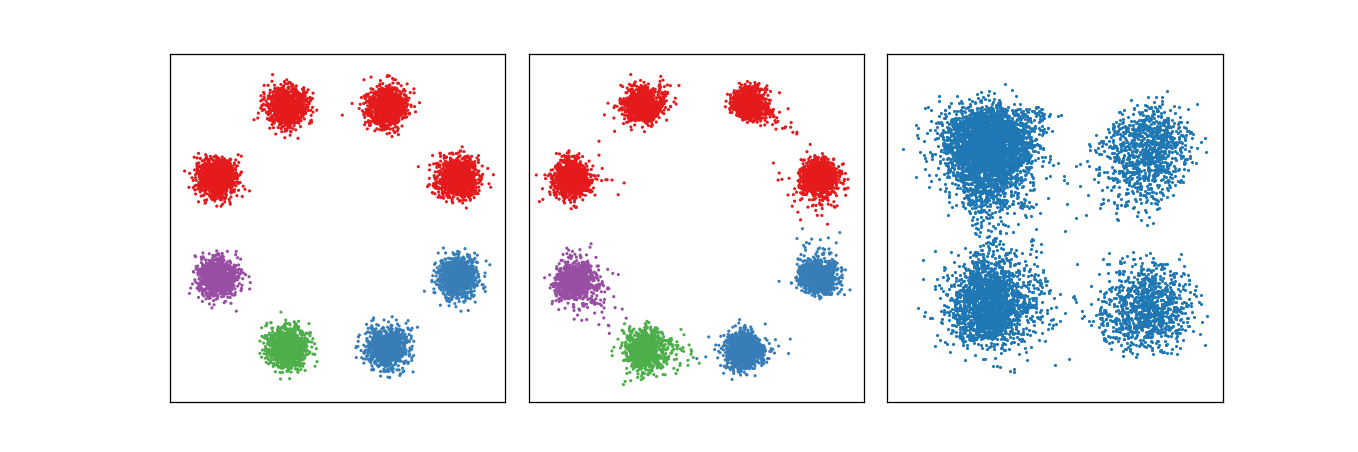

  0%|                                                   | 0/250 [00:00<?, ?it/s]

tensor([[0.2643, 0.2195, 0.2569, 0.2594],
        [0.2566, 0.2381, 0.2537, 0.2516],
        [0.2518, 0.2495, 0.2537, 0.2450],
        [0.2543, 0.2419, 0.2541, 0.2497]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


  4%|#6                                        | 10/250 [00:40<16:11,  4.05s/it]

tensor([[0.2637, 0.2298, 0.2586, 0.2479],
        [0.2588, 0.2385, 0.2552, 0.2475],
        [0.2547, 0.2531, 0.2547, 0.2375],
        [0.2554, 0.2476, 0.2549, 0.2421]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


  8%|###3                                      | 20/250 [01:19<14:50,  3.87s/it]

tensor([[0.2618, 0.2251, 0.2542, 0.2589],
        [0.2594, 0.2321, 0.2525, 0.2561],
        [0.2565, 0.2482, 0.2502, 0.2451],
        [0.2570, 0.2420, 0.2515, 0.2495]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 12%|#####                                     | 30/250 [01:58<14:20,  3.91s/it]

tensor([[0.2589, 0.2386, 0.2536, 0.2489],
        [0.2582, 0.2386, 0.2522, 0.2510],
        [0.2563, 0.2538, 0.2521, 0.2379],
        [0.2562, 0.2495, 0.2522, 0.2420]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 16%|######7                                   | 40/250 [02:37<13:42,  3.92s/it]

tensor([[0.2581, 0.2382, 0.2548, 0.2488],
        [0.2580, 0.2393, 0.2532, 0.2495],
        [0.2546, 0.2546, 0.2541, 0.2367],
        [0.2551, 0.2485, 0.2537, 0.2427]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 20%|########4                                 | 50/250 [03:15<12:56,  3.88s/it]

tensor([[0.2544, 0.2474, 0.2524, 0.2459],
        [0.2564, 0.2427, 0.2517, 0.2492],
        [0.2532, 0.2604, 0.2507, 0.2357],
        [0.2540, 0.2553, 0.2511, 0.2396]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 24%|##########                                | 60/250 [03:55<12:18,  3.89s/it]

tensor([[0.2535, 0.2455, 0.2514, 0.2497],
        [0.2568, 0.2439, 0.2504, 0.2490],
        [0.2536, 0.2721, 0.2448, 0.2294],
        [0.2545, 0.2633, 0.2467, 0.2354]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 28%|###########7                              | 70/250 [04:34<11:45,  3.92s/it]

tensor([[0.2508, 0.2470, 0.2506, 0.2517],
        [0.2567, 0.2460, 0.2478, 0.2495],
        [0.2557, 0.2916, 0.2361, 0.2166],
        [0.2556, 0.2723, 0.2420, 0.2301]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 32%|#############4                            | 80/250 [05:14<11:07,  3.93s/it]

tensor([[0.2503, 0.2550, 0.2524, 0.2423],
        [0.2582, 0.2543, 0.2480, 0.2396],
        [0.2498, 0.3848, 0.2099, 0.1555],
        [0.2540, 0.3290, 0.2288, 0.1882]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 36%|###############1                          | 90/250 [05:54<10:29,  3.93s/it]

tensor([[0.2488, 0.2529, 0.2488, 0.2495],
        [0.2600, 0.3009, 0.2226, 0.2166],
        [0.0966, 0.8360, 0.0438, 0.0236],
        [0.1599, 0.6865, 0.0929, 0.0608]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 40%|################4                        | 100/250 [06:32<09:42,  3.88s/it]

tensor([[2.4921e-01, 2.6863e-01, 2.3916e-01, 2.4300e-01],
        [2.7036e-01, 3.2218e-01, 1.9325e-01, 2.1420e-01],
        [2.0542e-03, 9.9714e-01, 5.1401e-04, 2.8932e-04],
        [6.1620e-03, 9.9069e-01, 1.9360e-03, 1.2074e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 44%|##################                       | 110/250 [07:12<09:12,  3.95s/it]

tensor([[2.4875e-01, 2.5964e-01, 2.4349e-01, 2.4812e-01],
        [2.8656e-01, 3.7603e-01, 1.4480e-01, 1.9262e-01],
        [3.9705e-04, 9.9948e-01, 7.1575e-05, 5.5516e-05],
        [1.0611e-03, 9.9852e-01, 2.3022e-04, 1.8591e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 48%|###################6                     | 120/250 [07:52<08:33,  3.95s/it]

tensor([[2.5507e-01, 2.5716e-01, 2.3934e-01, 2.4843e-01],
        [3.3883e-01, 4.4343e-01, 7.4804e-02, 1.4293e-01],
        [1.9912e-04, 9.9977e-01, 1.6808e-05, 1.9008e-05],
        [4.0555e-04, 9.9951e-01, 4.0982e-05, 4.6214e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 52%|#####################3                   | 130/250 [08:32<08:01,  4.01s/it]

tensor([[2.5574e-01, 2.5286e-01, 2.4419e-01, 2.4721e-01],
        [4.5526e-01, 4.6822e-01, 2.1370e-02, 5.5152e-02],
        [1.5879e-04, 9.9983e-01, 4.0673e-06, 5.2018e-06],
        [2.9051e-04, 9.9969e-01, 9.3646e-06, 1.1821e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 56%|######################9                  | 140/250 [09:13<07:34,  4.13s/it]

tensor([[2.5528e-01, 2.5313e-01, 2.4470e-01, 2.4688e-01],
        [4.6051e-01, 5.2299e-01, 4.3812e-03, 1.2115e-02],
        [1.0097e-04, 9.9990e-01, 9.9919e-07, 1.0890e-06],
        [1.7238e-04, 9.9982e-01, 2.2183e-06, 2.4068e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 60%|########################5                | 150/250 [09:53<06:38,  3.98s/it]

tensor([[2.4786e-01, 2.5229e-01, 2.5194e-01, 2.4791e-01],
        [4.8472e-01, 5.1019e-01, 1.4573e-03, 3.6295e-03],
        [7.3066e-05, 9.9993e-01, 4.1360e-07, 3.4450e-07],
        [1.1736e-04, 9.9988e-01, 8.9038e-07, 7.4370e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 64%|##########################2              | 160/250 [10:32<05:55,  3.95s/it]

tensor([[2.4321e-01, 2.5516e-01, 2.5436e-01, 2.4727e-01],
        [5.0175e-01, 4.9607e-01, 6.5849e-04, 1.5252e-03],
        [5.1813e-05, 9.9995e-01, 2.0186e-07, 1.4368e-07],
        [8.0475e-05, 9.9992e-01, 4.2141e-07, 3.0198e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 68%|###########################8             | 170/250 [11:13<05:25,  4.07s/it]

tensor([[2.4331e-01, 2.6230e-01, 2.4909e-01, 2.4530e-01],
        [5.0176e-01, 4.9708e-01, 3.5402e-04, 8.0353e-04],
        [3.7421e-05, 9.9996e-01, 1.0753e-07, 7.3451e-08],
        [5.6973e-05, 9.9994e-01, 2.2049e-07, 1.5144e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 72%|#############################5           | 180/250 [11:56<04:57,  4.26s/it]

tensor([[2.4558e-01, 2.6056e-01, 2.4782e-01, 2.4604e-01],
        [4.8230e-01, 5.1702e-01, 2.1498e-04, 4.5853e-04],
        [2.8006e-05, 9.9997e-01, 6.4691e-08, 4.0929e-08],
        [4.1553e-05, 9.9996e-01, 1.2850e-07, 8.1691e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 76%|###############################1         | 190/250 [12:38<04:16,  4.27s/it]

tensor([[2.4348e-01, 2.5493e-01, 2.5167e-01, 2.4992e-01],
        [5.0153e-01, 4.9802e-01, 1.4912e-04, 3.0425e-04],
        [2.3425e-05, 9.9998e-01, 4.6208e-08, 2.7099e-08],
        [3.3972e-05, 9.9997e-01, 8.9522e-08, 5.2710e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 80%|################################8        | 200/250 [13:17<02:56,  3.53s/it]

tensor([[2.3919e-01, 2.6395e-01, 2.4884e-01, 2.4802e-01],
        [5.2032e-01, 4.7938e-01, 1.0263e-04, 2.0594e-04],
        [1.9031e-05, 9.9998e-01, 3.1039e-08, 1.7468e-08],
        [2.7116e-05, 9.9997e-01, 5.8727e-08, 3.3128e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 84%|##################################4      | 210/250 [13:48<02:10,  3.27s/it]

tensor([[2.4471e-01, 2.5469e-01, 2.5170e-01, 2.4889e-01],
        [5.0063e-01, 4.9916e-01, 7.4647e-05, 1.4051e-04],
        [1.5674e-05, 9.9998e-01, 2.2608e-08, 1.1431e-08],
        [2.1932e-05, 9.9998e-01, 4.1810e-08, 2.1183e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 88%|####################################     | 220/250 [14:24<01:36,  3.23s/it]

tensor([[2.4002e-01, 2.5796e-01, 2.5323e-01, 2.4880e-01],
        [4.9496e-01, 5.0488e-01, 5.7080e-05, 1.0327e-04],
        [1.2610e-05, 9.9999e-01, 1.6540e-08, 7.9224e-09],
        [1.7388e-05, 9.9998e-01, 2.9972e-08, 1.4358e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 92%|#####################################7   | 230/250 [14:50<00:52,  2.61s/it]

tensor([[2.4893e-01, 2.6207e-01, 2.4547e-01, 2.4354e-01],
        [5.1631e-01, 4.8357e-01, 4.3407e-05, 7.7309e-05],
        [1.1193e-05, 9.9999e-01, 1.2165e-08, 5.7228e-09],
        [1.5167e-05, 9.9998e-01, 2.1559e-08, 1.0113e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 96%|#######################################3 | 240/250 [15:16<00:25,  2.56s/it]

tensor([[2.3756e-01, 2.6604e-01, 2.5014e-01, 2.4626e-01],
        [4.8450e-01, 5.1541e-01, 3.5525e-05, 6.1619e-05],
        [8.5938e-06, 9.9999e-01, 8.9796e-09, 4.0913e-09],
        [1.1543e-05, 9.9999e-01, 1.5676e-08, 7.1059e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


100%|#########################################| 250/250 [15:41<00:00,  3.77s/it]



Training took 15.69 minutes



In [10]:
model.to(device)

fig, axes = plt.subplots(1, 3,figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096
inp = torch.tensor([[1., 0., 0., 0.],[0., 1., 0., 0.],[0., 0., 1., 0.],[0., 0., 0., 1.]]).to(device)

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]

y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
for i in range(ndim_y):
    ind[:,i] = y_samps[:,i].bool()
y_samps += 0*torch.randn(N_samp, ndim_y)
y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
prob_c = prob_net(inp)
prob_sum = torch.cumsum(prob_c,1)
for i in range(ndim_y):
    shift = torch.rand([sum(ind[:,i].int()),]).float()
    for j in range(no_gaussians):
        shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
    y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
    y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
y_samps = y_samps.to(device)

            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)
        
        # New part
        y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
        c = np.where(y_samps)[1]
        ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
        for i in range(ndim_y):
            ind[:,i] = y_samps[:,i].bool()
        y_samps += 0* torch.randn(N_samp, ndim_y)
        y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
        prob_c = prob_net(inp)
        if np.mod(i_epoch,10)==0:
            print(prob_c)
        prob_sum = torch.cumsum(prob_c,1)
        y_samps = y_samps.to(device)
        for i in range(ndim_y):
            shift = torch.rand([sum(ind[:,i].int()),]).float()
            for j in range(no_gaussians):
                shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
            y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
            y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
        y_samps = y_samps.to(device)
        # End new part
        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, ndim_tot-ndim_y:].argmax(dim=1)
        z_val = model(torch.cat((x_samps, zeros_noise_scale * torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))
                
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:, 0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].set_xticks([])
        axes[2].set_yticks([])
    
    
        fig.canvas.draw()

    
        
    
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [11]:
# Tuned training parameters
n_epochs = 120
temp = 0.04
n_its_per_epoch = 8

lr_INN = 4e-4
lr_prob = 4e-4
l2_reg = 0.

# relative weighting of losses:
lambd_predict = 5.
lambd_latent = 150.
lambd_rev = 300.
lambd_pad = 0.
lambd_prob = 3.

Loss_ramp = False
Sparsity_Reg = False 

for g in optimizer.param_groups:
    g['lr'] = lr_INN
    g['weight_decay'] = l2_reg 
        
for g in optimizer2.param_groups:
    g['lr'] = lr_prob



<IPython.core.display.Javascript object>


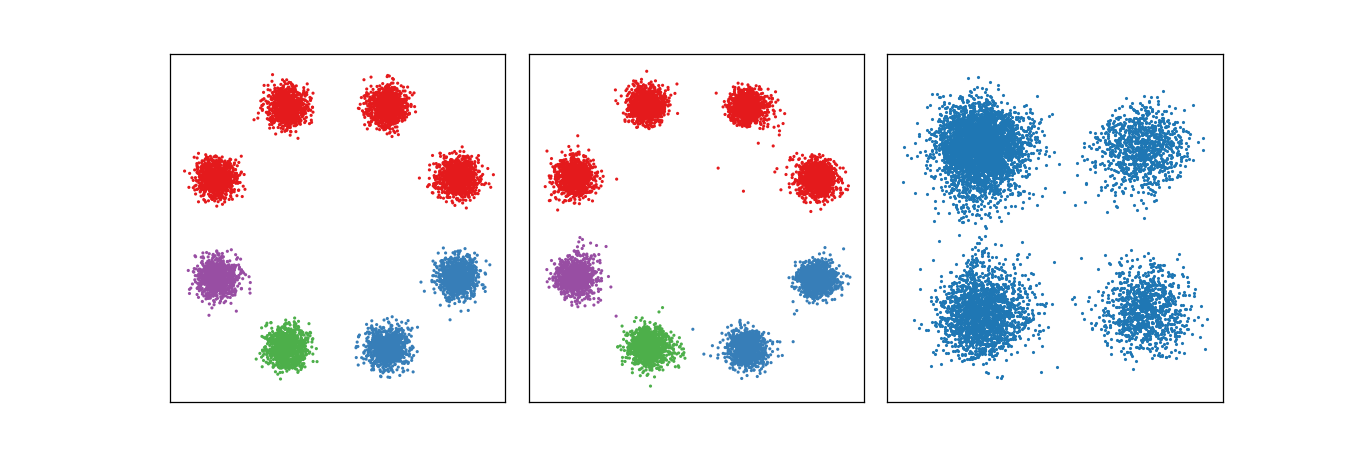

  0%|                                                   | 0/120 [00:00<?, ?it/s]

tensor([[2.3872e-01, 2.6160e-01, 2.5052e-01, 2.4917e-01],
        [4.9513e-01, 5.0479e-01, 2.9269e-05, 4.9802e-05],
        [7.9421e-06, 9.9999e-01, 7.3394e-09, 3.3291e-09],
        [1.0489e-05, 9.9999e-01, 1.2522e-08, 5.6338e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


  8%|###5                                      | 10/120 [00:25<04:41,  2.56s/it]

tensor([[2.3954e-01, 2.6139e-01, 2.5022e-01, 2.4885e-01],
        [4.9257e-01, 5.0735e-01, 2.9279e-05, 4.9800e-05],
        [7.9675e-06, 9.9999e-01, 7.3018e-09, 3.3395e-09],
        [1.0518e-05, 9.9999e-01, 1.2454e-08, 5.6483e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 17%|#######                                   | 20/120 [00:51<04:12,  2.52s/it]

tensor([[2.4672e-01, 2.5499e-01, 2.4921e-01, 2.4909e-01],
        [5.3521e-01, 4.6471e-01, 2.9716e-05, 5.0949e-05],
        [9.1404e-06, 9.9999e-01, 7.9857e-09, 3.6394e-09],
        [1.2084e-05, 9.9999e-01, 1.3621e-08, 6.1595e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 25%|##########5                               | 30/120 [01:16<03:46,  2.51s/it]

tensor([[2.4432e-01, 2.5114e-01, 2.5278e-01, 2.5177e-01],
        [5.2194e-01, 4.7797e-01, 3.0129e-05, 5.1217e-05],
        [8.9691e-06, 9.9999e-01, 8.0982e-09, 3.6511e-09],
        [1.1848e-05, 9.9999e-01, 1.3836e-08, 6.1893e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 33%|##############                            | 40/120 [01:42<03:37,  2.72s/it]

tensor([[2.4541e-01, 2.5441e-01, 2.5022e-01, 2.4996e-01],
        [5.0722e-01, 4.9270e-01, 2.9499e-05, 5.0331e-05],
        [8.3669e-06, 9.9999e-01, 7.5028e-09, 3.4121e-09],
        [1.1314e-05, 9.9999e-01, 1.3161e-08, 5.9507e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 42%|#################5                        | 50/120 [02:08<03:04,  2.64s/it]

tensor([[2.4468e-01, 2.5326e-01, 2.5054e-01, 2.5151e-01],
        [5.0945e-01, 4.9047e-01, 2.9271e-05, 5.0778e-05],
        [8.4076e-06, 9.9999e-01, 7.4468e-09, 3.4693e-09],
        [1.1382e-05, 9.9999e-01, 1.3092e-08, 6.0620e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 50%|#####################                     | 60/120 [02:34<02:33,  2.57s/it]

tensor([[2.4347e-01, 2.5435e-01, 2.5193e-01, 2.5024e-01],
        [5.0876e-01, 4.9116e-01, 2.9293e-05, 5.0257e-05],
        [8.4272e-06, 9.9999e-01, 7.5634e-09, 3.4286e-09],
        [1.1408e-05, 9.9999e-01, 1.3296e-08, 5.9927e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 58%|########################5                 | 70/120 [03:00<02:11,  2.64s/it]

tensor([[2.4301e-01, 2.5398e-01, 2.5306e-01, 2.4995e-01],
        [4.9876e-01, 5.0116e-01, 2.9243e-05, 4.9549e-05],
        [8.2994e-06, 9.9999e-01, 7.5348e-09, 3.3450e-09],
        [1.1402e-05, 9.9999e-01, 1.3482e-08, 5.9630e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 67%|############################              | 80/120 [03:26<01:42,  2.55s/it]

tensor([[2.4294e-01, 2.5604e-01, 2.5293e-01, 2.4809e-01],
        [4.9401e-01, 5.0591e-01, 2.9140e-05, 4.8901e-05],
        [8.1692e-06, 9.9999e-01, 7.4484e-09, 3.2496e-09],
        [1.1228e-05, 9.9999e-01, 1.3332e-08, 5.7964e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 75%|###############################5          | 90/120 [03:52<01:18,  2.63s/it]

tensor([[2.4755e-01, 2.5368e-01, 2.5080e-01, 2.4797e-01],
        [4.9960e-01, 5.0032e-01, 2.8922e-05, 4.9037e-05],
        [8.4707e-06, 9.9999e-01, 7.4720e-09, 3.3337e-09],
        [1.1656e-05, 9.9999e-01, 1.3364e-08, 5.9410e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 83%|##################################1      | 100/120 [04:19<00:52,  2.63s/it]

tensor([[2.4978e-01, 2.5191e-01, 2.5045e-01, 2.4787e-01],
        [5.0968e-01, 4.9024e-01, 2.8543e-05, 4.9054e-05],
        [8.8072e-06, 9.9999e-01, 7.5426e-09, 3.4087e-09],
        [1.2117e-05, 9.9999e-01, 1.3486e-08, 6.0712e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 92%|#####################################5   | 110/120 [04:45<00:26,  2.66s/it]

tensor([[2.4598e-01, 2.5127e-01, 2.5362e-01, 2.4914e-01],
        [5.0580e-01, 4.9412e-01, 2.8494e-05, 4.9154e-05],
        [8.6691e-06, 9.9999e-01, 7.5148e-09, 3.4062e-09],
        [1.1909e-05, 9.9999e-01, 1.3463e-08, 6.0757e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


100%|#########################################| 120/120 [05:12<00:00,  2.60s/it]



Training took 5.20 minutes



In [12]:
model.to(device)

fig, axes = plt.subplots(1, 3,figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096
inp = torch.tensor([[1., 0., 0., 0.],[0., 1., 0., 0.],[0., 0., 1., 0.],[0., 0., 0., 1.]]).to(device)

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]

y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
for i in range(ndim_y):
    ind[:,i] = y_samps[:,i].bool()
y_samps += 0*torch.randn(N_samp, ndim_y)
y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
prob_c = prob_net(inp)
prob_sum = torch.cumsum(prob_c,1)
for i in range(ndim_y):
    shift = torch.rand([sum(ind[:,i].int()),]).float()
    for j in range(no_gaussians):
        shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
    y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
    y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
y_samps = y_samps.to(device)

            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)
        
        # New part
        y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
        c = np.where(y_samps)[1]
        ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
        for i in range(ndim_y):
            ind[:,i] = y_samps[:,i].bool()
        y_samps += 0* torch.randn(N_samp, ndim_y)
        y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
        prob_c = prob_net(inp)
        if np.mod(i_epoch,10)==0:
            print(prob_c)
        prob_sum = torch.cumsum(prob_c,1)
        y_samps = y_samps.to(device)
        for i in range(ndim_y):
            shift = torch.rand([sum(ind[:,i].int()),]).float()
            for j in range(no_gaussians):
                shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
            y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
            y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
        y_samps = y_samps.to(device)
        # End new part
        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, ndim_tot-ndim_y:].argmax(dim=1)
        z_val = model(torch.cat((x_samps, zeros_noise_scale * torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))
    

                
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:, 0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].set_xticks([])
        axes[2].set_yticks([])


        if i_epoch == n_epochs-1:
        
            plt.savefig('LL.png', bbox_inches = 'tight')
    
        fig.canvas.draw()

    
        
    
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [13]:
torch.save(model.state_dict(), 'STABLE_8_LL.pt')
torch.save(prob_net.state_dict(), 'STABLE_8_LL_probs.pt')

In [14]:
print(prob_net(inp))

tensor([[2.4818e-01, 2.5030e-01, 2.5174e-01, 2.4978e-01],
        [4.9779e-01, 5.0213e-01, 2.8187e-05, 4.9080e-05],
        [8.5651e-06, 9.9999e-01, 7.2831e-09, 3.3706e-09],
        [1.1774e-05, 9.9999e-01, 1.3047e-08, 6.0105e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
